# 0. Instructions

**Follow the universal workflow of DLWP 4.5 (1st edition) for a problem and dataset of your choice**.

You can use the tensorflow datasets, MNIST, Reuters, IMDB and Boston Housing Price, or an external dataset. Work exclusively in this Jupyter notebook.

**You can only use DLWP Part 1 layers (Chapters 1-4) i.e. restrict your models to tensorflow sequential Dense and Dropout layers**.

A text cell and sometimes a code cell follows each section heading. These cells are for your response to the section title. The text that you add in these cells form the major component of the awarded grade. The aim is to use the section headings to construct a formal project report. What you did, and why, and what was the outcome: explanations, interpretations, evaluations and conclusions. You can add cells; above all, you must prepare a well-structured and readable document.

You can use as much DLWP code and code from the video notebooks as you wish but you must reference all code that is not original.

Export this Jupyter notebook to html and submit. Do not submit this notebook or any data files. Submit only the html export of this notebook.

(For Colab users: Colab does not have an html facility. Either:
Download the colab notebook and load into Jupyter; you will then be able to export as html
or

Follow the instructions in this blog https://python.plainenglish.io/how-to-convert-google-colab-notebook-ipynb-to-html-ccfeda199246 i.e. download from colab and then reload into colab's session storage. Then run the script
%%shelljupyter nbconvert --to html /Your notebook path/file.ipynb
and download the html version.)


# 1. Problem definition and dataset

Sentiment analysis is a subfield of Natural Language Processing (NLP) that focuses on identifying and extracting subjective information from text data. It is widely used in various domains such as social media monitoring, marketing to analyze customer reviews, and the entertainment industry to gauge viewers sentiment towards content and guide filmakers into making better movies and TV shows.

The ability to automatically classify text as expressing a positive or negative sentiment is a fundamental task in sentiment analysis.

In this exercise I aim to use the IMDB dataset to tackle the problem of sentiment classification, the goal is to develop a model that can accurately classify the sentiment of movie reviews.

The dataset consist of 50,000 movie reviews labeled as either positive or negative.

I'm going to be targetting an accuracy of 80% or higher, as we are classifing sentiment on movie reviews I consider that accuracy to be good enough for the project, if this model were to be used for medical diagnosis then I would try to target a higher accuracy and prediction precision.

# 2. Success metric(s)

As this is a binary classification problem (positive vs negative sentiment), I'm going to be using the following metrics to measure success of the model:

* Accuracy gives me the ratio of correctly predicted instances (both positive and negative) to the tostal instances. Gives a general sense of how often the model is correct.

Defined as:
$Accuracy = \frac{True Positives + True Negatives}{Total Number of Samples}$

At first I'm only going to be used accuracy as a guiding metric, once I stat to fine tune the model a bit more I'll start to introduce the following metrics for comparison:

* Precision: The ratio of correctly predicted positive instances to the total predicted positive. Measures the accuracy of the positive predictions.

Defined as:
$Precision = \frac{True Positives}{True Positives + False Positives}$

* Recall: Measures the ability of a model to correctly identify all relevant instances for classification\

Defined as:
$Recall = \frac{True Positives}{True Positives + False Negatives}$



# 3. Evaluation protocol

For my evaluation protocol I'll be maintaing a hold-out validation set. Meaning I'll be splitting the data set into three distinct subsets:
* Training Set: Used to train the model
* Validation Set: Used to fine-tune the model's hyperparameters and prevent overfitting
* Test Set: Used to assess the final performance of the model on new unseen data.

Reasoning for choosing this method:
* Prevents Data Leakage: This method ensures that the validation and test data are kept completely separate from the training data. This separation prevents data leakage, where information from the test set might inadvertently influence the model, leading to overly optimistic performance estimates.
* Effective for large datasets: When a large amount of data is available, the hold-out mehitd is effective as it allows sufcfient data for both training the model and evaluating it.
* Addresses Time Dependency in a Time Series Dataset: By partitioning the data chronologically, we ensure that the model is trained on past data and evaluated on future data, which reflects the real-world scenario where predictions are made for future time points based on historical observations.

# 4. Data preparation

The IMDB dataset from keras is provided with already splitted datasets, one for training and one for testing holding 25k reviews each. The reviews are already pre-processed by turning the words into sequences of integers.

A dictionary is provided to convert these back into their original form if needed, let's do this for inspecting the data for a moment.

In [100]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
word_index = imdb.get_word_index()


def decode_review(dictionary, review):
    reverse_index = {}
    for word, index in dictionary.items():
        reverse_index[index] = word
    
    decoded_review = []
    for word_index in review:
        decoded_review.append(reverse_index.get(word_index - 3, '?'))
    
    return ' '.join(decoded_review)

print(decode_review(word_index, train_data[0]))

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

We can't feed these list of integers into a neural network, so we need to transform it into something we can use as an input. As we can only use Dense layers I'm going to one-hot encode the lists to turm them into vectors of 0s and 1s, if not word embeddings could be a better option for this as they capture the semantic relationship in between words which can improve generalization.

In [101]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# 5. Gaining statistical power

With the dataset ready, I'm going to build a very basic model that should beat a baseline accuracy of 0.5. As this dataset is balanced with 50% positive and 50% negative reviews if I were to guess the sentiment of each review randomly I would be correct hald the time. Therefore a naive model with no learning would achieve a baseline accuracy of 50%.

For this basic model I will use a single input layer and one hidden layer with 16 neurons for both, with an output layer with 1 neuron using the `sigmoid` activation algorithm..

I'm going to use the `rmsprop` optimizer and the `binary_crossentropy` loss function as a starting point. The model will be initially trained for 20 epochs.

In [102]:
from keras import models, layers

baseline_model = models.Sequential()
baseline_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
baseline_model.add(layers.Dense(16, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

baseline_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

baseline_history = baseline_model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 24ms/step - loss: 0.5264 - accuracy: 0.7859 - val_loss: 0.4005 - val_accuracy: 0.8710
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3219 - accuracy: 0.8999 - val_loss: 0.3224 - val_accuracy: 0.8829
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2337 - accuracy: 0.9244 - val_loss: 0.3240 - val_accuracy: 0.8675
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1864 - accuracy: 0.9401 - val_loss: 0.2794 - val_accuracy: 0.8873
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1498 - accuracy: 0.9509 - val_loss: 0.3311 - val_accuracy: 0.8688
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1277 - accuracy: 0.9589 - val_loss: 0.2967 - val_accuracy: 0.8848
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1073 - accuracy: 0.9669 - val_loss: 0.3054 - val_accuracy: 0.8840
Epoch 8/20
30/30 [=

Now with the model train let's compare the training and validation the loss and accuracy of the model.

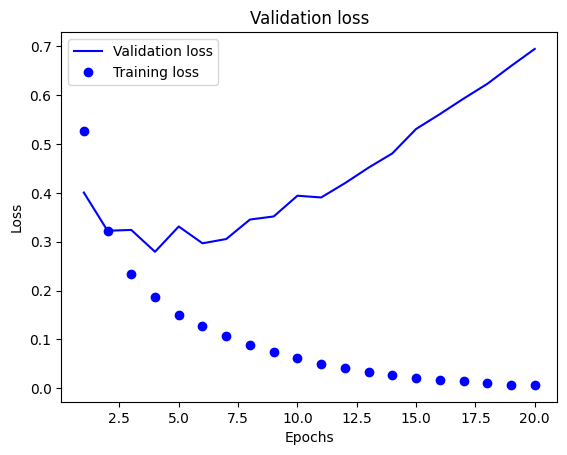

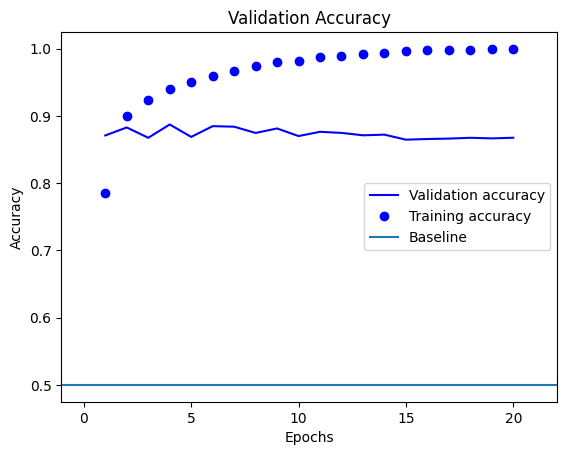

In [103]:
import matplotlib.pyplot as plt

baseline_loss = baseline_history.history['loss']
baseline_val_loss = baseline_history.history['val_loss']
baseline_accuracy = baseline_history.history['accuracy']
baseline_val_accuracy = baseline_history.history['val_accuracy']

epochs = range(1, len(baseline_loss) + 1)

plt.plot(epochs, baseline_val_loss, 'b', label="Validation loss")
plt.plot(epochs, baseline_loss, 'bo', label="Training loss")
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, baseline_val_accuracy, 'b', label="Validation accuracy")
plt.plot(epochs, baseline_accuracy, 'bo', label="Training accuracy")
plt.axline((0, 0.50), (len(baseline_loss)+1, 0.50), label="Baseline")
plt.title("Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The basic model beats the baseline hence achieving statistical power, also the upwards trend of the validation loss and slight downward trend of the validation accuracy could be pointing at an overfitting model that peaks at around epoch 4 or 5.

# 6. Scaling up

In this section I'm going to be attempting to answer the question "Is my model sufficently powerful?", my previous model was slightly overfitting as it probably doesn't have enough capacity to adjust itself to the dataset.

I'm going to start by adding an additional hidden layer to the model and increasting its capacity, then I will compare its performance against the previous model.

In [104]:
histories = []

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

first_iteration = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))


Epoch 1/20
30/30 [==============================] - 1s 16ms/step - loss: 0.5047 - accuracy: 0.7731 - val_loss: 0.3729 - val_accuracy: 0.8681
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2848 - accuracy: 0.9039 - val_loss: 0.2969 - val_accuracy: 0.8854
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2050 - accuracy: 0.9301 - val_loss: 0.3243 - val_accuracy: 0.8752
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1590 - accuracy: 0.9467 - val_loss: 0.2925 - val_accuracy: 0.8840
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1210 - accuracy: 0.9605 - val_loss: 0.4128 - val_accuracy: 0.8608
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0923 - accuracy: 0.9726 - val_loss: 0.3287 - val_accuracy: 0.8840
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0722 - accuracy: 0.9793 - val_loss: 0.3690 - val_accuracy: 0.8811
Epoch 8/20
30/30 [

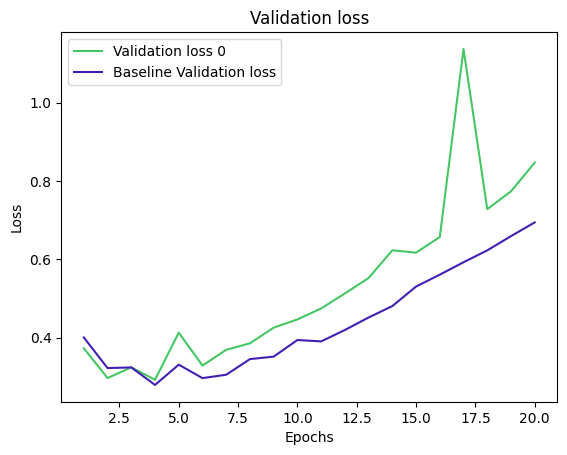

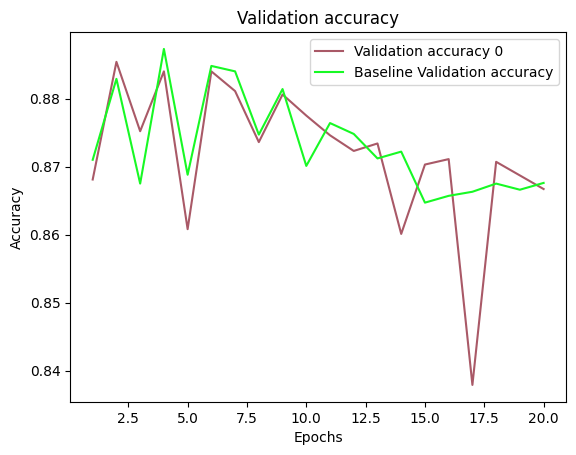

In [105]:
val_loss = first_iteration.history['val_loss']

plt.plot(epochs, val_loss, label=f"Validation loss {i}", color=np.random.rand(3,))
plt.plot(epochs, baseline_val_loss, label=f"Baseline Validation loss", color=np.random.rand(3,))
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

val_accuracy = first_iteration.history['val_accuracy']

plt.plot(epochs, val_accuracy, label=f"Validation accuracy {i}", color=np.random.rand(3,))
plt.plot(epochs, baseline_val_accuracy, label=f"Baseline Validation accuracy", color=np.random.rand(3,))
plt.title("Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

For this iteration both accuracy and loss seems to be slightly worse. I want to try the opposite now, reducing the network size to see the difference.

In [108]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

second_iteration = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 23ms/step - loss: 0.5708 - accuracy: 0.7762 - val_loss: 0.4692 - val_accuracy: 0.8638
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3879 - accuracy: 0.8973 - val_loss: 0.3649 - val_accuracy: 0.8842
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2895 - accuracy: 0.9181 - val_loss: 0.3169 - val_accuracy: 0.8834
Epoch 4/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2295 - accuracy: 0.9348 - val_loss: 0.2894 - val_accuracy: 0.8915
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1868 - accuracy: 0.9461 - val_loss: 0.2895 - val_accuracy: 0.8827
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1586 - accuracy: 0.9533 - val_loss: 0.2911 - val_accuracy: 0.8834
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1342 - accuracy: 0.9629 - val_loss: 0.2824 - val_accuracy: 0.8887
Epoch 8/20
30/30 [=

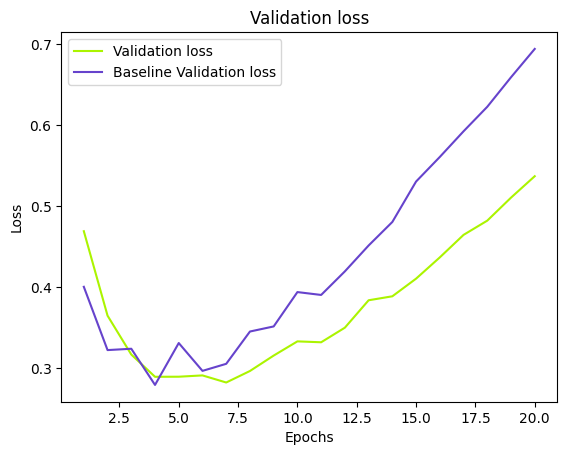

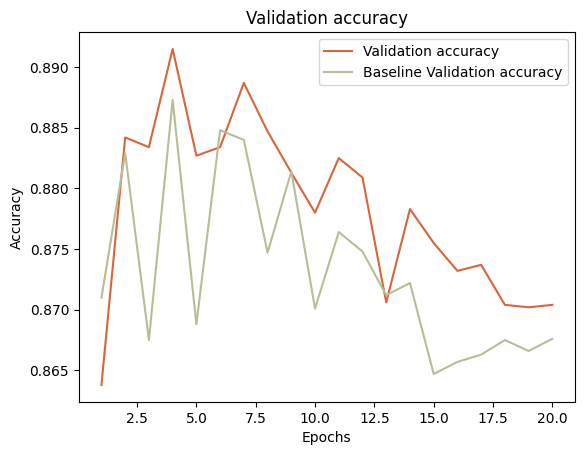

In [115]:
val_loss = second_iteration.history['val_loss']

plt.plot(epochs, val_loss, label=f"Validation loss", color=np.random.rand(3,))
plt.plot(epochs, baseline_val_loss, label=f"Baseline Validation loss", color=np.random.rand(3,))
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

val_accuracy = second_iteration.history['val_accuracy']

plt.plot(epochs, val_accuracy, label=f"Validation accuracy", color=np.random.rand(3,))
plt.plot(epochs, baseline_val_accuracy, label=f"Baseline Validation accuracy", color=np.random.rand(3,))
plt.title("Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

Accuracy seems to overall trend higher and loss lower that the baseline model. I want to verify if the improvement comes from the reduction of layers or neurons, so I'm going to add an additional layer and see what happens.

In [116]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

third_iteration = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 27ms/step - loss: 0.5592 - accuracy: 0.7776 - val_loss: 0.4545 - val_accuracy: 0.8454
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3680 - accuracy: 0.8913 - val_loss: 0.3588 - val_accuracy: 0.8651
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2740 - accuracy: 0.9140 - val_loss: 0.3048 - val_accuracy: 0.8835
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2142 - accuracy: 0.9319 - val_loss: 0.2806 - val_accuracy: 0.8891
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1777 - accuracy: 0.9436 - val_loss: 0.2761 - val_accuracy: 0.8883
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1488 - accuracy: 0.9531 - val_loss: 0.2831 - val_accuracy: 0.8869
Epoch 7/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1252 - accuracy: 0.9637 - val_loss: 0.2966 - val_accuracy: 0.8827
Epoch 8/20
30/30 [=

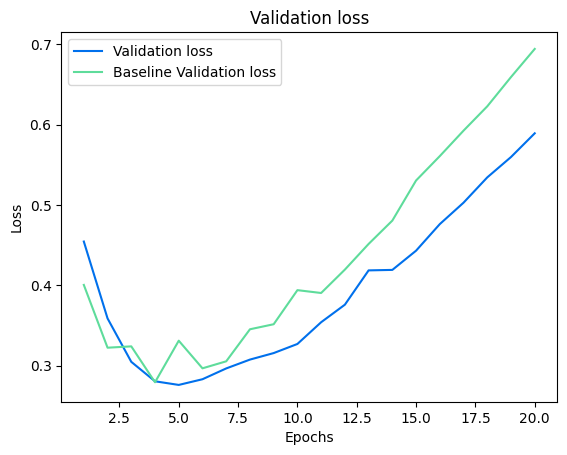

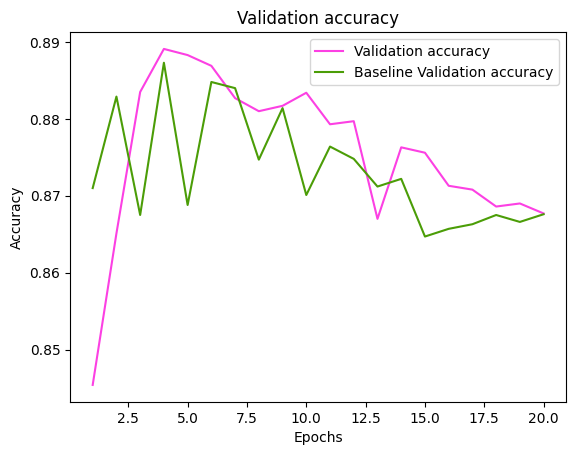

In [117]:
val_loss = third_iteration.history['val_loss']

plt.plot(epochs, val_loss, label=f"Validation loss", color=np.random.rand(3,))
plt.plot(epochs, baseline_val_loss, label=f"Baseline Validation loss", color=np.random.rand(3,))
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

val_accuracy = third_iteration.history['val_accuracy']

plt.plot(epochs, val_accuracy, label=f"Validation accuracy", color=np.random.rand(3,))
plt.plot(epochs, baseline_val_accuracy, label=f"Baseline Validation accuracy", color=np.random.rand(3,))
plt.title("Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

The model with this dataset seems to improve when there's an additional layer but keeping the same capacity, accuracy trends higher and loss trends lower altough it reaches the same minimums as the baseline model it has a more smooth descent and peaks at about epoch 8.

Now I want to start tackling a bit the problem of overfitting, one of the first things we can do for this before hyperparameter tuning and regularization is to increase the training data. Now I don't have access to more data than what the dataset is providing me currently, but I want to tweak the amount of data we use for validation and traning in this same model and compare results, right now we are using 15k records to train and 10k for validation, let's add more records for training.

I'm curious to see the difference here, but I'm not expecting the model to reduce its overfitting as I'm not introducing new data, just reshuffling it.

In [118]:
x_val = x_train[:5000]
partial_x_train = x_train[15000:]

y_val = y_train[:5000]
partial_y_train = y_train[15000:]

more_trained_model_history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]


Epoch 1/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0075 - accuracy: 0.9996 - val_loss: 0.6111 - val_accuracy: 0.8676
Epoch 2/20
20/20 [==============================] - 0s 5ms/step - loss: 0.0091 - accuracy: 0.9984 - val_loss: 0.6770 - val_accuracy: 0.8622
Epoch 3/20
20/20 [==============================] - 0s 5ms/step - loss: 0.0043 - accuracy: 0.9998 - val_loss: 0.6545 - val_accuracy: 0.8666
Epoch 4/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.6744 - val_accuracy: 0.8662
Epoch 5/20
20/20 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.9998 - val_loss: 0.7445 - val_accuracy: 0.8594
Epoch 6/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.7333 - val_accuracy: 0.8644
Epoch 7/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.7763 - val_accuracy: 0.8664
Epoch 8/20
20/20 [=

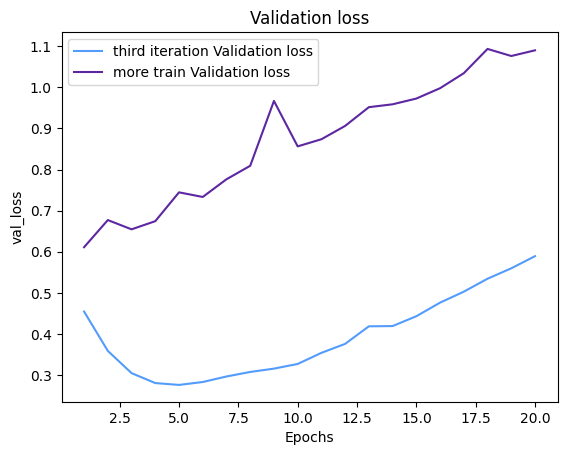

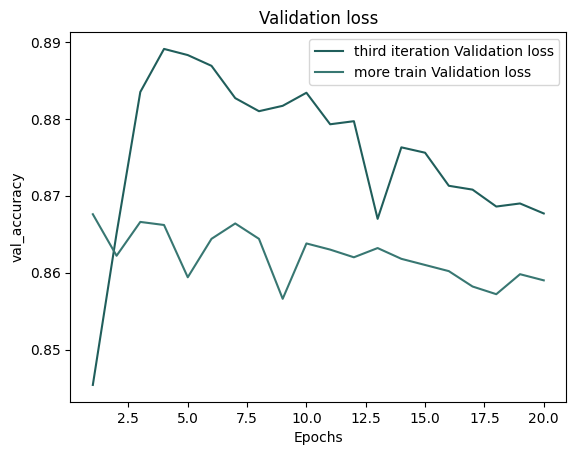

In [139]:
def plot_with_previous(epochs, previous_history, current_history, previous_label="", current_label=""):
    metrics = {'val_loss': "Validation loss", 'val_accuracy': "Validation accuracy"}

    for m in metrics:
        plt.plot(epochs, previous_history.history[m], label=f"{previous_label} Validation loss", color=np.random.rand(3,))
        plt.plot(epochs, current_history.history[m], label=f"{current_label} Validation loss", color=np.random.rand(3,))
        plt.title("Validation loss")
        plt.xlabel('Epochs')
        plt.ylabel(m)

        plt.legend()
        plt.show()

plot_with_previous(epochs=epochs, previous_history=third_iteration, current_history=more_trained_model_history, previous_label="third iteration", current_label="more train")

As expected, the model with more train data seems to have a much higher and sharp loss line, it would make sense as it has less validation data to tune its hyperparameters as training happens. So I will be taking the previous model on the next stage, and apply regularisation to it.

# 7. Regularisation and tuning

In this section I'm going to attempt to balance the model, ideally we would have a less sharp descension on the accuracy and we see a con

In [125]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

tuning_first_iteration = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 27ms/step - loss: 0.5944 - accuracy: 0.7529 - val_loss: 0.5011 - val_accuracy: 0.8407
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4242 - accuracy: 0.8815 - val_loss: 0.3882 - val_accuracy: 0.8770
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3219 - accuracy: 0.9047 - val_loss: 0.3268 - val_accuracy: 0.8852
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2542 - accuracy: 0.9229 - val_loss: 0.2919 - val_accuracy: 0.8896
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2076 - accuracy: 0.9335 - val_loss: 0.2761 - val_accuracy: 0.8911
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1734 - accuracy: 0.9445 - val_loss: 0.2773 - val_accuracy: 0.8906
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1489 - accuracy: 0.9524 - val_loss: 0.2777 - val_accuracy: 0.8891
Epoch 8/20
30/30 [=

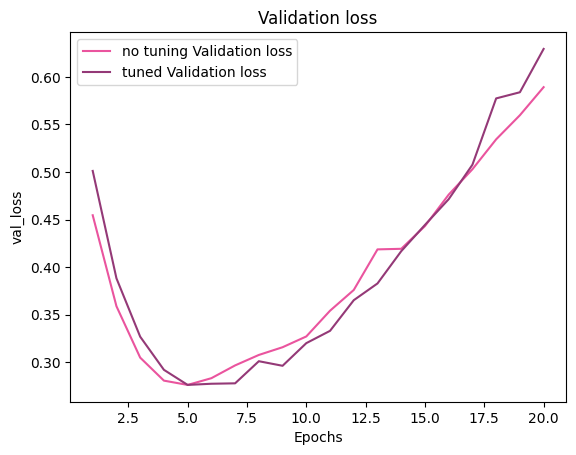

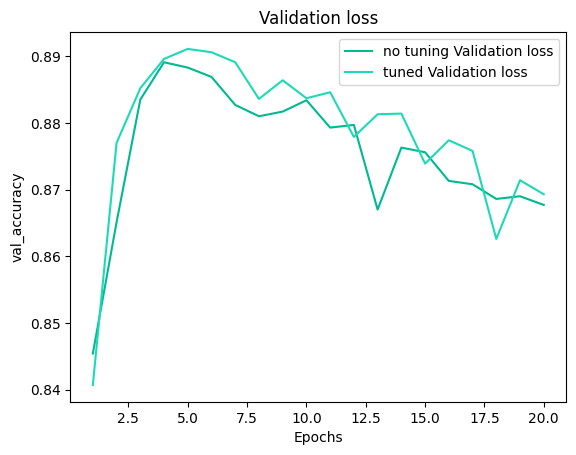

In [138]:
plot_with_previous(epochs=epochs, previous_history=third_iteration, current_history=tuning_first_iteration, previous_label="no tuning", current_label="tuned")

Having a single dropout layer after the input, results in a higher acurracy at epoch 6. I'm going to add an additional dropout layer after the next hidden layer and compare.

In [131]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

tuning_second_iteration = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 27ms/step - loss: 0.5552 - accuracy: 0.7746 - val_loss: 0.4434 - val_accuracy: 0.8575
Epoch 2/20
30/30 [==============================] - 0s 6ms/step - loss: 0.3550 - accuracy: 0.8883 - val_loss: 0.3377 - val_accuracy: 0.8792
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2606 - accuracy: 0.9170 - val_loss: 0.3101 - val_accuracy: 0.8780
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2072 - accuracy: 0.9320 - val_loss: 0.2761 - val_accuracy: 0.8899
Epoch 5/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1657 - accuracy: 0.9460 - val_loss: 0.2842 - val_accuracy: 0.8882
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1387 - accuracy: 0.9531 - val_loss: 0.2891 - val_accuracy: 0.8851
Epoch 7/20
30/30 [==============================] - 0s 4ms/step - loss: 0.1180 - accuracy: 0.9600 - val_loss: 0.3028 - val_accuracy: 0.8825
Epoch 8/20
30/30 [=

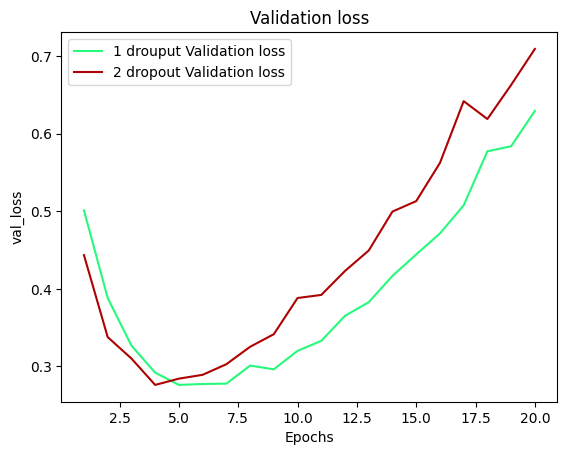

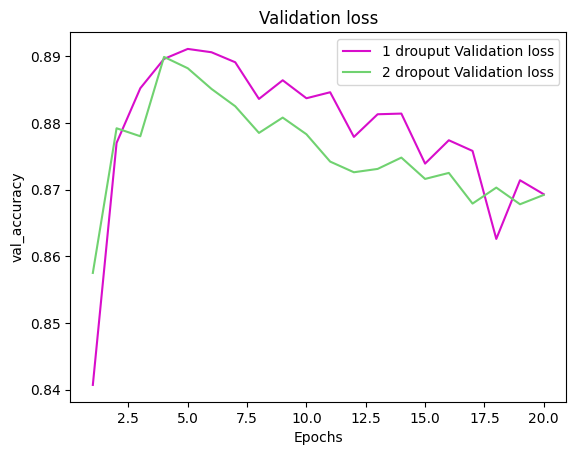

In [140]:
plot_with_previous(epochs=epochs, previous_history=tuning_first_iteration, current_history=tuning_second_iteration, previous_label="1 drouput", current_label="2 dropout")

Having two dropout layers seems to degrade the performance of the model, the first one still performs better on the validation data. I'm going to test a third dropout layer just to compare it to the original model.

In [141]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

tuning_thid_iteration = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 26ms/step - loss: 0.6265 - accuracy: 0.6695 - val_loss: 0.5484 - val_accuracy: 0.7418
Epoch 2/20
30/30 [==============================] - 0s 6ms/step - loss: 0.5150 - accuracy: 0.8250 - val_loss: 0.5017 - val_accuracy: 0.8642
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.4619 - accuracy: 0.8816 - val_loss: 0.5032 - val_accuracy: 0.8163
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4259 - accuracy: 0.9073 - val_loss: 0.4814 - val_accuracy: 0.8519
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.3113 - accuracy: 0.9292 - val_loss: 0.3207 - val_accuracy: 0.8791
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1926 - accuracy: 0.9417 - val_loss: 0.3088 - val_accuracy: 0.8836
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1591 - accuracy: 0.9512 - val_loss: 0.3008 - val_accuracy: 0.8856
Epoch 8/20
30/30 [=

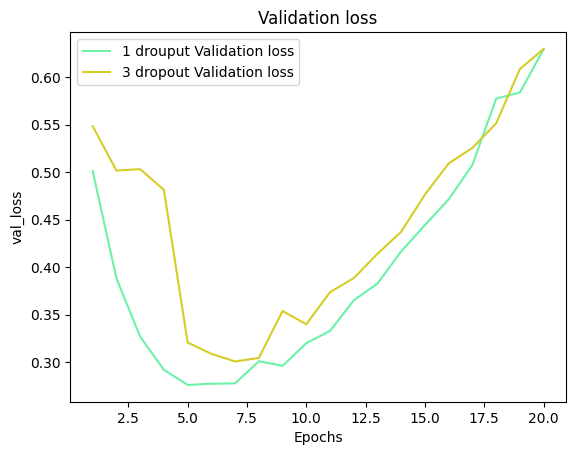

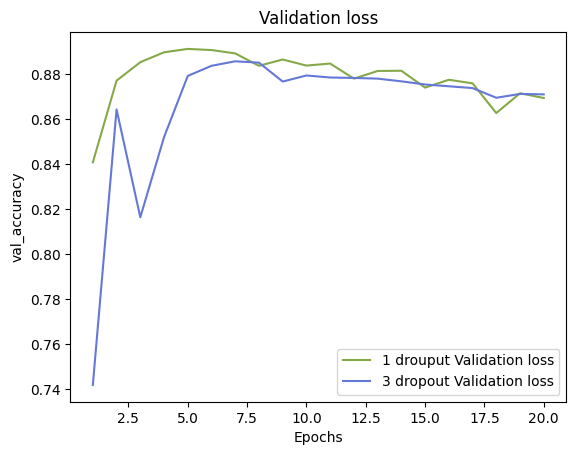

In [144]:
plot_with_previous(epochs=epochs, previous_history=tuning_first_iteration, current_history=tuning_thid_iteration, previous_label="1 drouput", current_label="3 dropout")

As expected the original model with a single dropout layer still performs better, let's adjust the rate now and see if there's an improvement when dropping more data.

In [169]:
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.05))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

tuning_fourth_iteration = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.6121 - accuracy: 0.7082 - val_loss: 0.5196 - val_accuracy: 0.8513
Epoch 2/20
30/30 [==============================] - 0s 6ms/step - loss: 0.4540 - accuracy: 0.8631 - val_loss: 0.4310 - val_accuracy: 0.8243
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3534 - accuracy: 0.8890 - val_loss: 0.3545 - val_accuracy: 0.8667
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2807 - accuracy: 0.9106 - val_loss: 0.3060 - val_accuracy: 0.8887
Epoch 5/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2298 - accuracy: 0.9281 - val_loss: 0.2970 - val_accuracy: 0.8862
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.1855 - accuracy: 0.9441 - val_loss: 0.2937 - val_accuracy: 0.8847
Epoch 7/20
30/30 [==============================] - 0s 4ms/step - loss: 0.1567 - accuracy: 0.9543 - val_loss: 0.2919 - val_accuracy: 0.8886
Epoch 8/20
30/30 [=

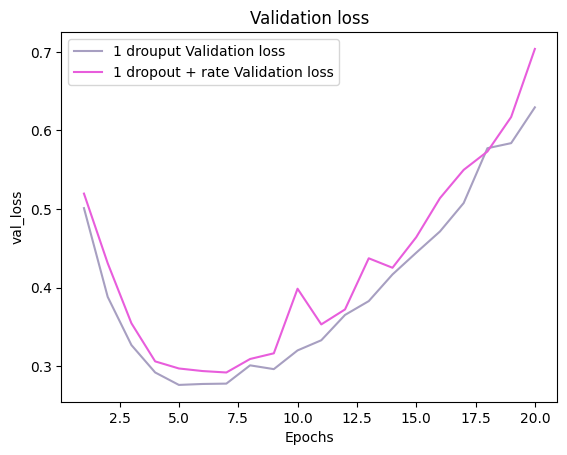

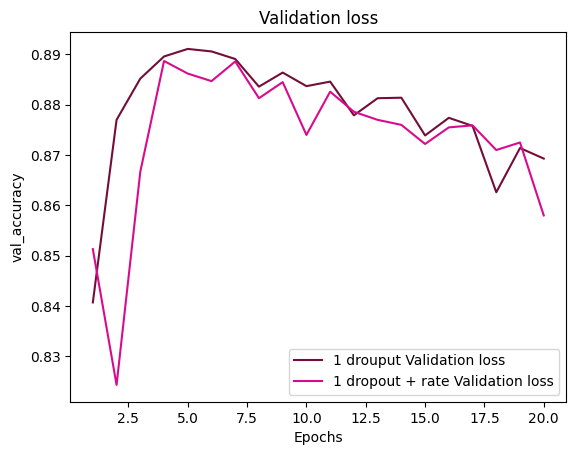

In [170]:
plot_with_previous(epochs=epochs, previous_history=tuning_first_iteration, current_history=tuning_fourth_iteration, previous_label="1 drouput", current_label="1 dropout + rate")

Increasing the rate doesn't improve the accuracy of the model. Now I do want to extract some additional metrics beyond accuracy and compare them back to the model without the dropout layer. I want to see the model's precision, recall and f1-score. These metrics 

In [214]:
def plot_with_previous_additional_metrics(epochs, previous_history, current_history, previous_label="", current_label=""):
    metrics = {"loss": "Tranining loss", "accuracy": "Traning Accuracy", 'val_loss': "Validation loss", 'val_accuracy': "Validation accuracy", 'val_precision': "Validation Precision", "val_recall": "Validation Recall"}

    for m in metrics:
        plt.plot(epochs, previous_history.history[m], label=f"{previous_label} {metrics[m]}", color=np.random.rand(3,))
        plt.plot(epochs, current_history.history[m], label=f"{current_label} {metrics[m]}", color=np.random.rand(3,))
        plt.title(metrics[m])
        plt.xlabel('Epochs')
        plt.ylabel(m)

        plt.legend()
        plt.show()

from keras import metrics

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

tuning_fourth_iteration_with_additional_metrics = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))


Epoch 1/20
30/30 [==============================] - 1s 32ms/step - loss: 0.5932 - accuracy: 0.7572 - precision: 0.8528 - recall: 0.6176 - val_loss: 0.5023 - val_accuracy: 0.8418 - val_precision: 0.9145 - val_recall: 0.7578
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.4209 - accuracy: 0.8828 - precision: 0.9014 - recall: 0.8578 - val_loss: 0.3874 - val_accuracy: 0.8652 - val_precision: 0.9140 - val_recall: 0.8094
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3124 - accuracy: 0.9054 - precision: 0.9087 - recall: 0.8998 - val_loss: 0.3270 - val_accuracy: 0.8783 - val_precision: 0.9175 - val_recall: 0.8342
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2456 - accuracy: 0.9220 - precision: 0.9225 - recall: 0.9202 - val_loss: 0.2931 - val_accuracy: 0.8872 - val_precision: 0.8598 - val_recall: 0.9282
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2014 - accuracy: 0.9356 - precision: 

In [221]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

third_iteration_with_additional_metrics = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 31ms/step - loss: 0.6367 - accuracy: 0.7780 - precision: 0.7357 - recall: 0.8629 - val_loss: 0.5743 - val_accuracy: 0.8589 - val_precision: 0.8856 - val_recall: 0.8276
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.5077 - accuracy: 0.8864 - precision: 0.8827 - recall: 0.8894 - val_loss: 0.4668 - val_accuracy: 0.8695 - val_precision: 0.8440 - val_recall: 0.9100
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.3957 - accuracy: 0.9055 - precision: 0.9042 - recall: 0.9057 - val_loss: 0.3817 - val_accuracy: 0.8802 - val_precision: 0.8765 - val_recall: 0.8880
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3107 - accuracy: 0.9183 - precision: 0.9168 - recall: 0.9189 - val_loss: 0.3302 - val_accuracy: 0.8858 - val_precision: 0.9056 - val_recall: 0.8640
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.2511 - accuracy: 0.9290 - precision:

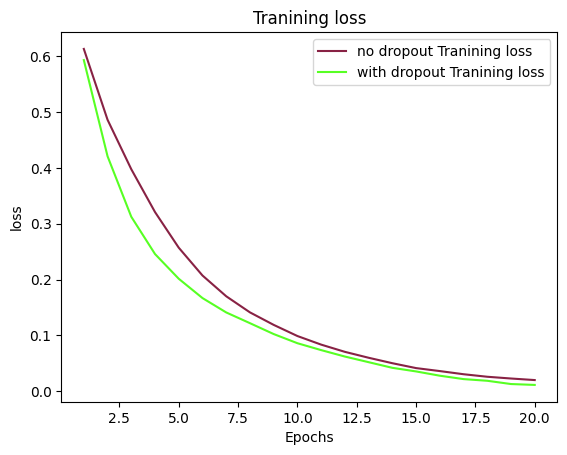

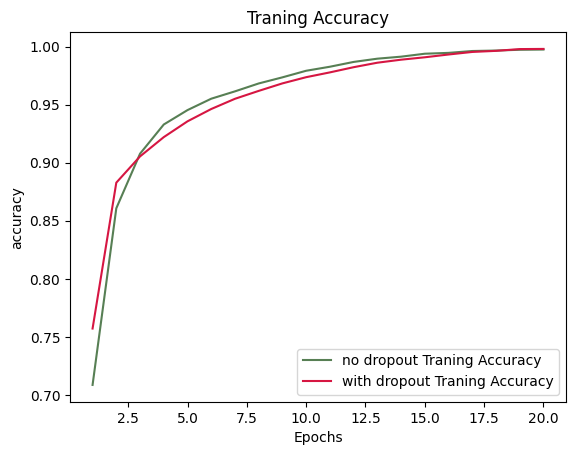

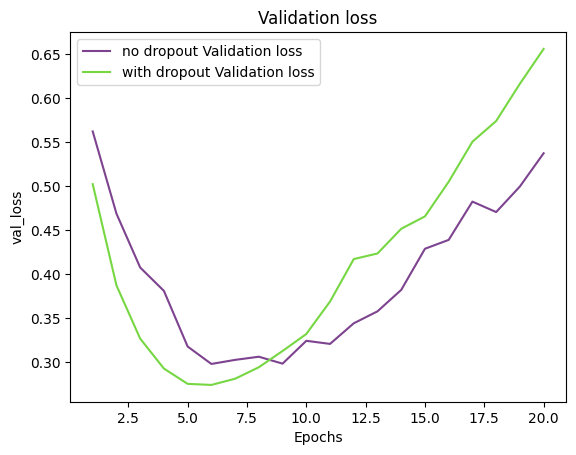

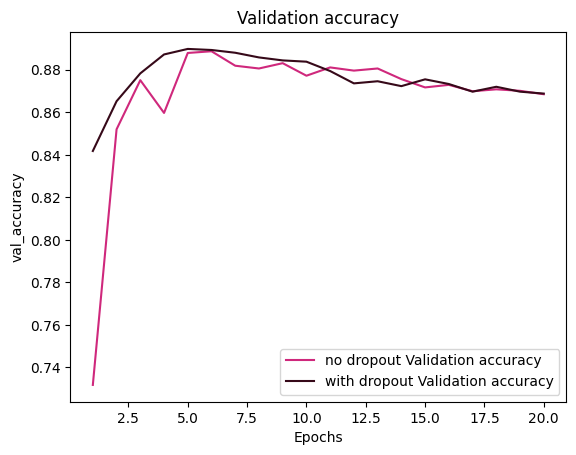

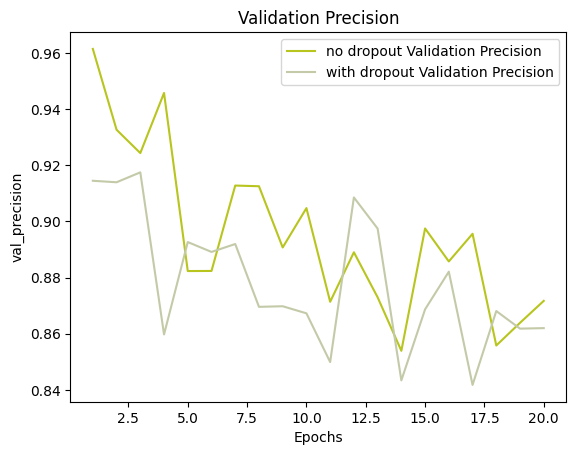

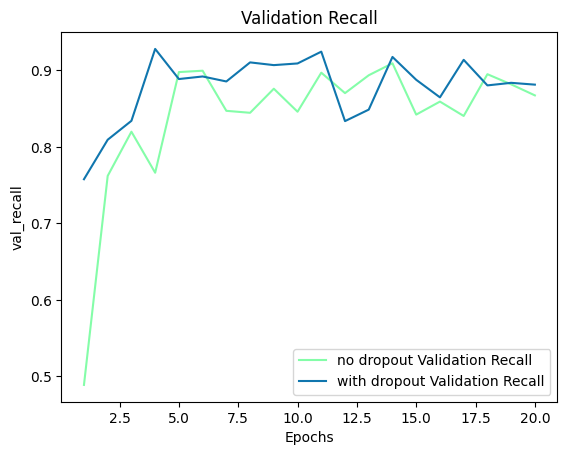

In [216]:
plot_with_previous_additional_metrics(epochs=epochs, previous_history=third_iteration_with_additional_metrics, current_history=tuning_fourth_iteration_with_additional_metrics, previous_label="no dropout", current_label="with dropout")

Looks like the model with dropout performs better on the other metrics too, 

In [217]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

tuning_fourth_iteration_with_additional_metrics_and_adam = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6227 - accuracy: 0.5592 - precision: 0.8627 - recall: 0.1333 - val_loss: 0.5519 - val_accuracy: 0.5724 - val_precision: 0.9555 - val_recall: 0.1613
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.4865 - accuracy: 0.7598 - precision: 0.9468 - recall: 0.5469 - val_loss: 0.4881 - val_accuracy: 0.8526 - val_precision: 0.9321 - val_recall: 0.7639
Epoch 3/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4256 - accuracy: 0.9065 - precision: 0.9513 - recall: 0.8555 - val_loss: 0.4705 - val_accuracy: 0.8737 - val_precision: 0.9125 - val_recall: 0.8296
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3919 - accuracy: 0.9331 - precision: 0.9561 - recall: 0.9068 - val_loss: 0.4646 - val_accuracy: 0.8753 - val_precision: 0.9089 - val_recall: 0.8371
Epoch 5/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3675 - accuracy: 0.9473 - precision: 

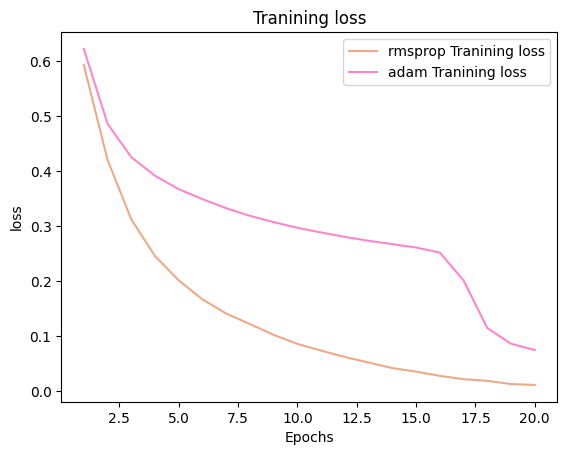

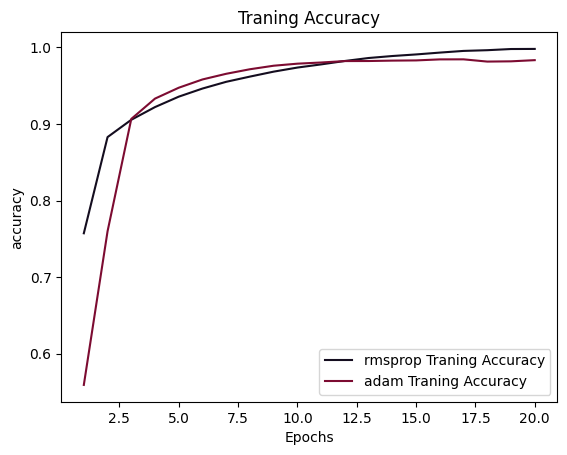

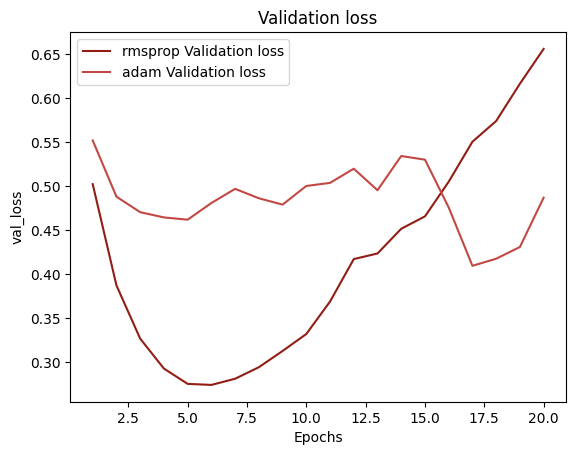

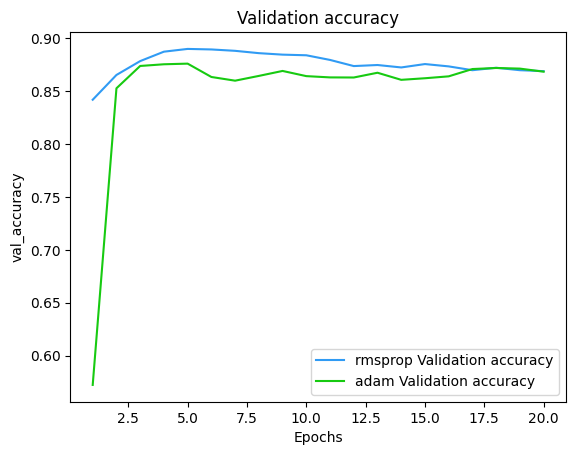

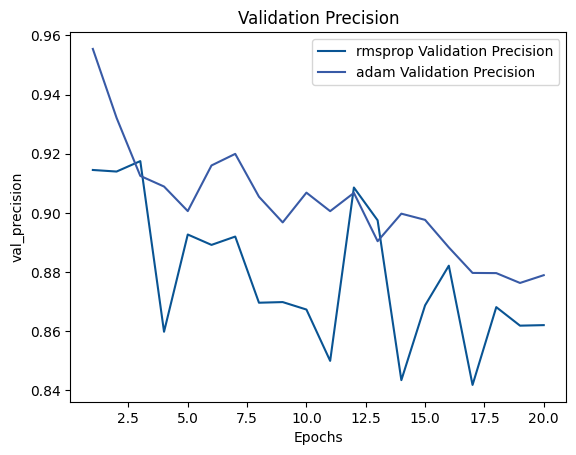

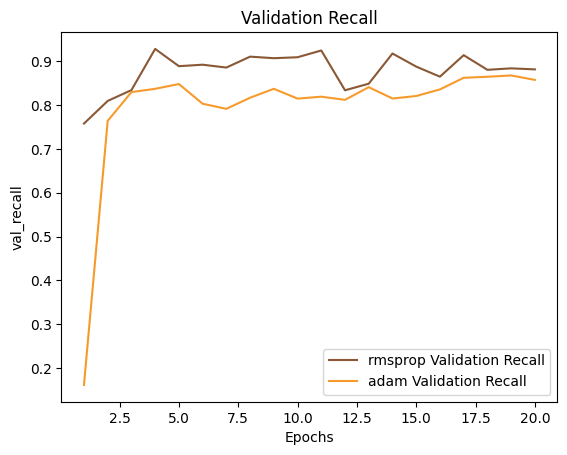

In [219]:
plot_with_previous_additional_metrics(epochs=epochs, previous_history=tuning_fourth_iteration_with_additional_metrics, current_history=tuning_fourth_iteration_with_additional_metrics_and_adam, previous_label="rmsprop", current_label="adam")

Now I want to try to have bigger batch sizes, this can lead to less noisy updates to the model parameters, which can result in fater convergence but potentially worse generalization. I want to see if my last model is the best I can get given the amount of data I have available. It is possible that the level of convergence currently reached is the best we can get with the amount of training data we have available currently.

In [224]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.01))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

tuning_fourth_iteration_with_additional_metrics_and_bigger_batch_size = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=1024, validation_data=(x_val, y_val))

Epoch 1/20
15/15 [==============================] - 2s 72ms/step - loss: 0.6372 - accuracy: 0.7154 - precision: 0.7278 - recall: 0.6816 - val_loss: 0.5639 - val_accuracy: 0.8382 - val_precision: 0.8031 - val_recall: 0.9007
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 0.5057 - accuracy: 0.8685 - precision: 0.8549 - recall: 0.8853 - val_loss: 0.4711 - val_accuracy: 0.8597 - val_precision: 0.8216 - val_recall: 0.9226
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 0.4117 - accuracy: 0.8957 - precision: 0.8817 - recall: 0.9123 - val_loss: 0.4019 - val_accuracy: 0.8791 - val_precision: 0.8686 - val_recall: 0.8963
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 0.3451 - accuracy: 0.9066 - precision: 0.8945 - recall: 0.9204 - val_loss: 0.3568 - val_accuracy: 0.8837 - val_precision: 0.8662 - val_recall: 0.9105
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 0.2922 - accuracy: 0.9196 - precision:

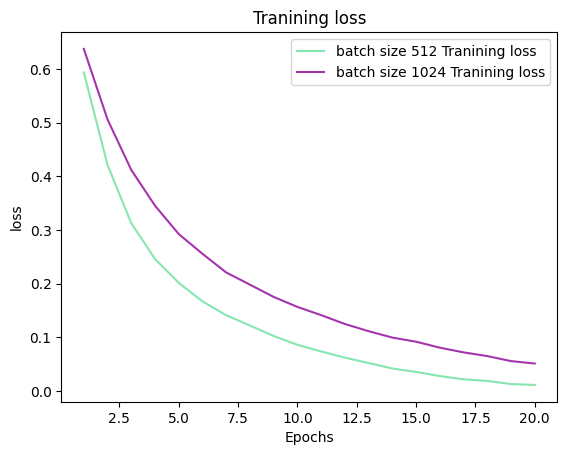

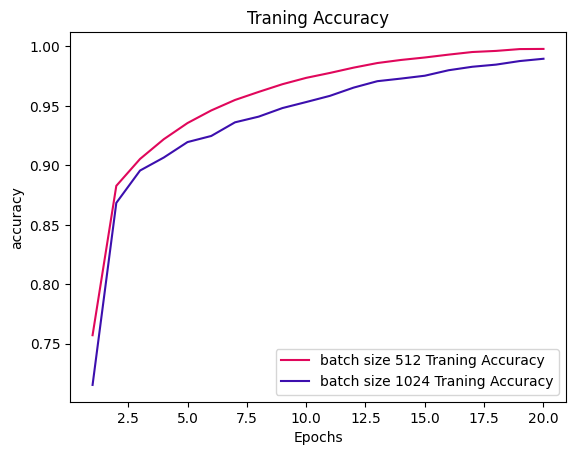

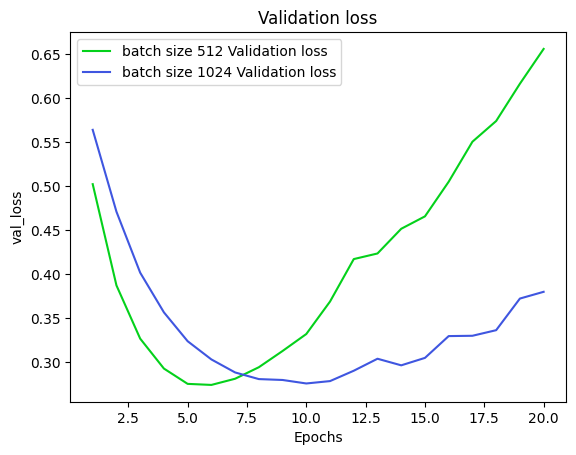

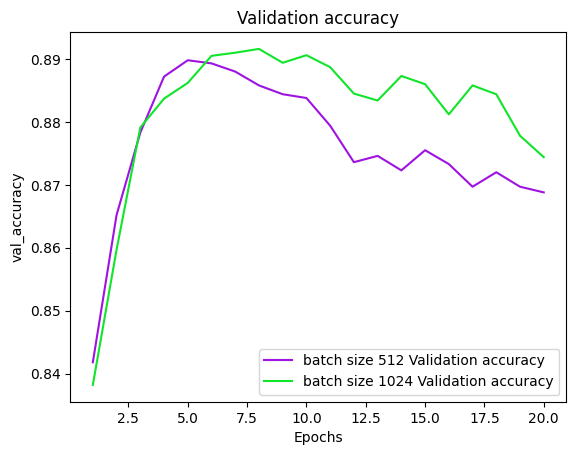

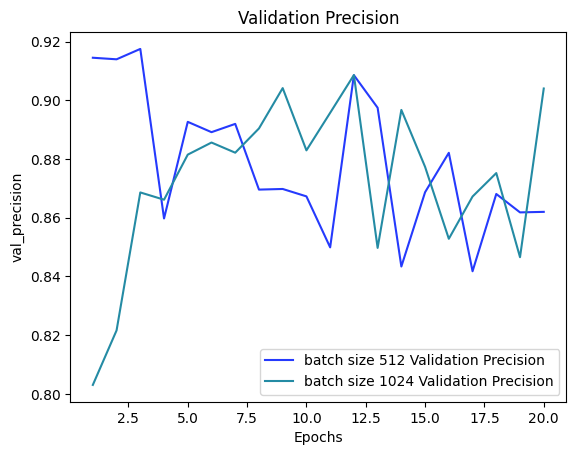

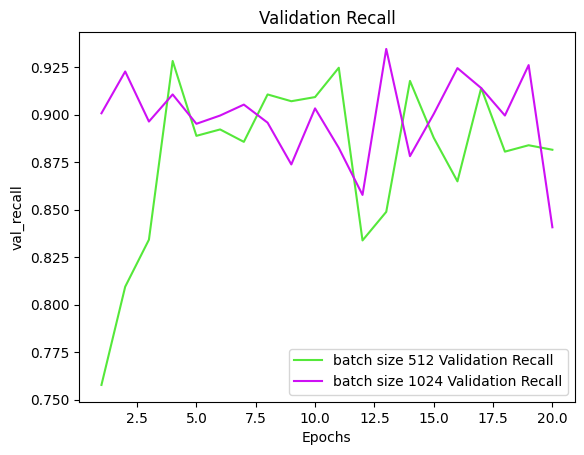

In [225]:
plot_with_previous_additional_metrics(epochs=epochs, previous_history=tuning_fourth_iteration_with_additional_metrics, current_history=tuning_fourth_iteration_with_additional_metrics_and_bigger_batch_size, previous_label="batch size 512", current_label="batch size 1024")

This seems like an improvement, accuracy is slightly higher and validation loss has a much less sharper ascent after it plateaus at epoch 8. This looks like the model is generalizing to unseen data better than it used to as a bigger batch size involves less noise being introduced on each of the training epochs.

This is the model I'll use for the next section when evaluating it using the test data.

In [226]:
final_model = tuning_fourth_iteration_with_additional_metrics_and_bigger_batch_size

# 8. Evaluation

With the model tuned, I'm going to evaluate the performance of the sentiment analysis model on the IMDB test set. To provide a comprehensive assessment, I'm going to employ several evaluation metrics, including accuracy, precision, recall, F1-score. These metrics offer insights into different aspects of the model's performance, such as its ability to correctly classify reviews (accuracy), its balance between false positives and false negatives (precision and recall).

Response

In [43]:
# code

# 9. Conclusion

Response

In [44]:
# code